In [ ]:
import sys
sys.path.append('../')

from raypy.utils.vector3 import vec3
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from functools import reduce as reduce
from mpl_toolkits.mplot3d import axes3d

# Ray Tracer

## Einleitung

Auf Deutsch bezeichnet der englische Begriff „Ray tracing“ das „Nachverfolgen von Strahlen“. Genauer gesagt: Lichtstrahlen. Als Grafik-Technologie ermöglicht Ray tracing die Simulierung von Lichteffekten. Ein Algorithmus sendet hierzu Strahlen in einer 3D-Grafik aus, verfolgt die Strahlenpfade und berechnet ein realistisches Beleuchtungsmodell.

In der realen Welt senden Lichtquellen Lichtstrahlen aus, die dann auf Objekte treffen, dort gebrochen, reflektiert oder gestreut werden und schlussendlich bei der Kamera ankommen.
Die von der Kamera erfassten Lichtstrahlen sind deshalb nur ein Bruchteil der Lichtstrahlen, die von der Lichtquelle zwar ausgesendet, von der Kamera aber nicht aufgenommen werden.

Um nur die, für die Kamera wichtigen, Lichtstrahlen zu berechnen, wird der Weg des Lichts beim Ray tracing entgegen der natürlichen Richtung berechnet.
Die Lichtstrahlen werden also von der Kamera ausgesendet und zurückverfolgt. Die folgende Grafik zeigt wie ein Ray aus der Kamera durch die Bildebene in den drei dimensionalen Raum gesendet wird.

<img src="assets/rayTracingOverview.png" width=500></img>

Beim Ray tracing werden ausgehend vom Augpunkt für jeden Pixel der Bildebene wird ein Ray ausgesendet. Die Rays durchstoßen die Bildebene und treffen dann auf die Objekte im drei dimensionalen Raum.
Die Farbe eines jeden Pixels der Bildebene wird durch die sog. Rendergleichung berechnet.


Eine vereinfachte Beschreibung wäre folgende:

Wenn der Strahl ein Objekt in der Szene schneidet, wird die Farbe des Pixels 
die der Strahl durchläuft, mit der Farbe des Objekts an diesem 
Schnittpunkts gesetzt.

<img src="assets/campixel.gif" alt="this slowpoke moves"  width="500" />

## Was ist ein Ray

Ein Ray, oder auch ein Lichtstrahl, ist die Kombination aus einem Ursprung und einer Richtung.
Ursprung und Richtung eines Rays können jeweils durch einen Vektor angegeben werden. Durch die Linearkombination 
des Ortsvektors (Ursprung) und des Richtungsvektors kann so jeder beliebige Punkt auf einem Ray angegeben werden.

<img src="assets/ray.png" width=300></img>

Die Gleichung für eine Ray ist also folgenden: $P(t)=\vec{O}+\vec{R}*t$

Die einfachste Implementierung eins Rays wäre also folgende:

In [ ]:
class Ray:
  """Info of the ray and the media it's travelling"""

  def __init__(self, origin, dir):
      self.origin = origin  # the point where the ray comes from
      self.dir = dir  # direction of the ray

## Die Kamera

Die Kamera befindet sich am Augpunkt und schaut in eine definierte Richtung. Die Anzahl der ausgesendeten Rays hängt von der Anzahl der Pixel ab. 

Die Besonderheit dieser Kamera ist, dass mittels *numpy* alle Rays parallel berechnet werden. Diese Rays können dann wiederum mit *numpy* parallel getrayed werden. So kann das Bild hoch parallel berechnet werden und die Rechendauer verringert sich um ein Vielfaches.

In [ ]:
class Camera():
    def __init__(self, look_from, look_at, screen_width=400, screen_height=400, field_of_view=90.):
        self.screen_width = screen_width
        self.screen_height = screen_height
        self.aspect_ratio = float(screen_width) / screen_height
        self.look_from = look_from
        self.look_at = look_at
        self.camera_width = np.tan(field_of_view * np.pi / 180 / 2.) * 2.
        self.camera_height = self.camera_width / self.aspect_ratio

        # camera reference basis in world coordinates
        self.cameraFwd = (look_at - look_from).normalize()
        self.cameraRight = (self.cameraFwd.cross(vec3(0., 1., 0.))).normalize()
        self.cameraUp = self.cameraRight.cross(self.cameraFwd)

        # Pixels coordinates in camera basis:
        self.x = np.linspace(-self.camera_width / 2., self.camera_width / 2., self.screen_width)
        self.y = np.linspace(self.camera_height / 2., -self.camera_height / 2., self.screen_height)

        # x holds all x values
        # y holds all y values
        # meshgrid creates a rectangular grid with all combinations of (x,y)
        # xx and yy hold the x and y values of the rectangular grid: https://stackoverflow.com/a/42404323
        xx, yy = np.meshgrid(self.x, self.y)
        self.x = xx.flatten()
        self.y = yy.flatten()

    def get_ray(self):

        # in each pixel, take a random position to avoid aliasing.
        x = self.x + (np.random.rand(len(self.x)) - 0.5) * self.camera_width / self.screen_width
        y = self.y + (np.random.rand(len(self.y)) - 0.5) * self.camera_height / self.screen_height

        # set ray direction in world space:
        # ray_origin = self.look_from + self.cameraUp + self.cameraRight
        ray_origin = self.look_from
        ray_dir = (self.look_from + self.cameraUp * y + self.cameraRight * x + self.cameraFwd - ray_origin).normalize()
        return Ray(origin=ray_origin, dir=ray_dir)


Die Berechnung der Rays erfolgt über eine Rasterisierung der Projektionsebene.
Die Projektionsebene befindet sich in z-Richtung eine Einheit von der Kamera entfernt.
Die Projektionsebene hat bei einem quadratischen Bild eine Abmessung von 2x2.
Mit `np.linspace` können gleichmäßig verteilte Zahlen über ein bestimmtes Intervall erstellt werden.

Bei einer Projektionsebene von 2x2 ist `camera_width` und `camera_height` bei 2.
Der folgende Code erzeugt also eine Array mit Werten von -1 bis 1 für x und für y.
Die Anzahl der Werte ist `screen_width` für die x Werte und `screen_height` für die y Werte.

```python
self.x = np.linspace(-self.camera_width / 2., self.camera_width / 2., self.screen_width)
self.y = np.linspace(self.camera_height / 2., -self.camera_height / 2., self.screen_height)
```

<img src="assets/rastertoworld.gif" height="500" />


### Die Funktion get_ray

Die Funktion get_ray gibt screen_width * screen_height Rays zurück.

Der Augpunkt (die Position der Kamera) wird als Stützvektor des Rays verwendet. Die Richtung des Rays kann über eine Linearkombination der Basis des Kamera Koordinatensystems generiert werden. Als Faktoren werden die im Voraus berechneten Kombinationen von x und y Werten verwendet.

Um Aliasing zu vermeiden, werden alle x und y Werte mit einem zufälligen Offset versehen. Wird das Bild dann mit mehreren Samples berechnet geht der Aliasing Effekt verloren.

In [50]:
camera = Camera(screen_width=1600 ,screen_height=900, look_from = vec3(0, 0, 10), look_at = vec3(0,0,0), field_of_view= 90)
rays = camera.get_ray()

Visualisiert man die Richtung der Rays als RGB Wert kann eine Bild generiert werden, dass die Richtung der Rays veranschaulicht.

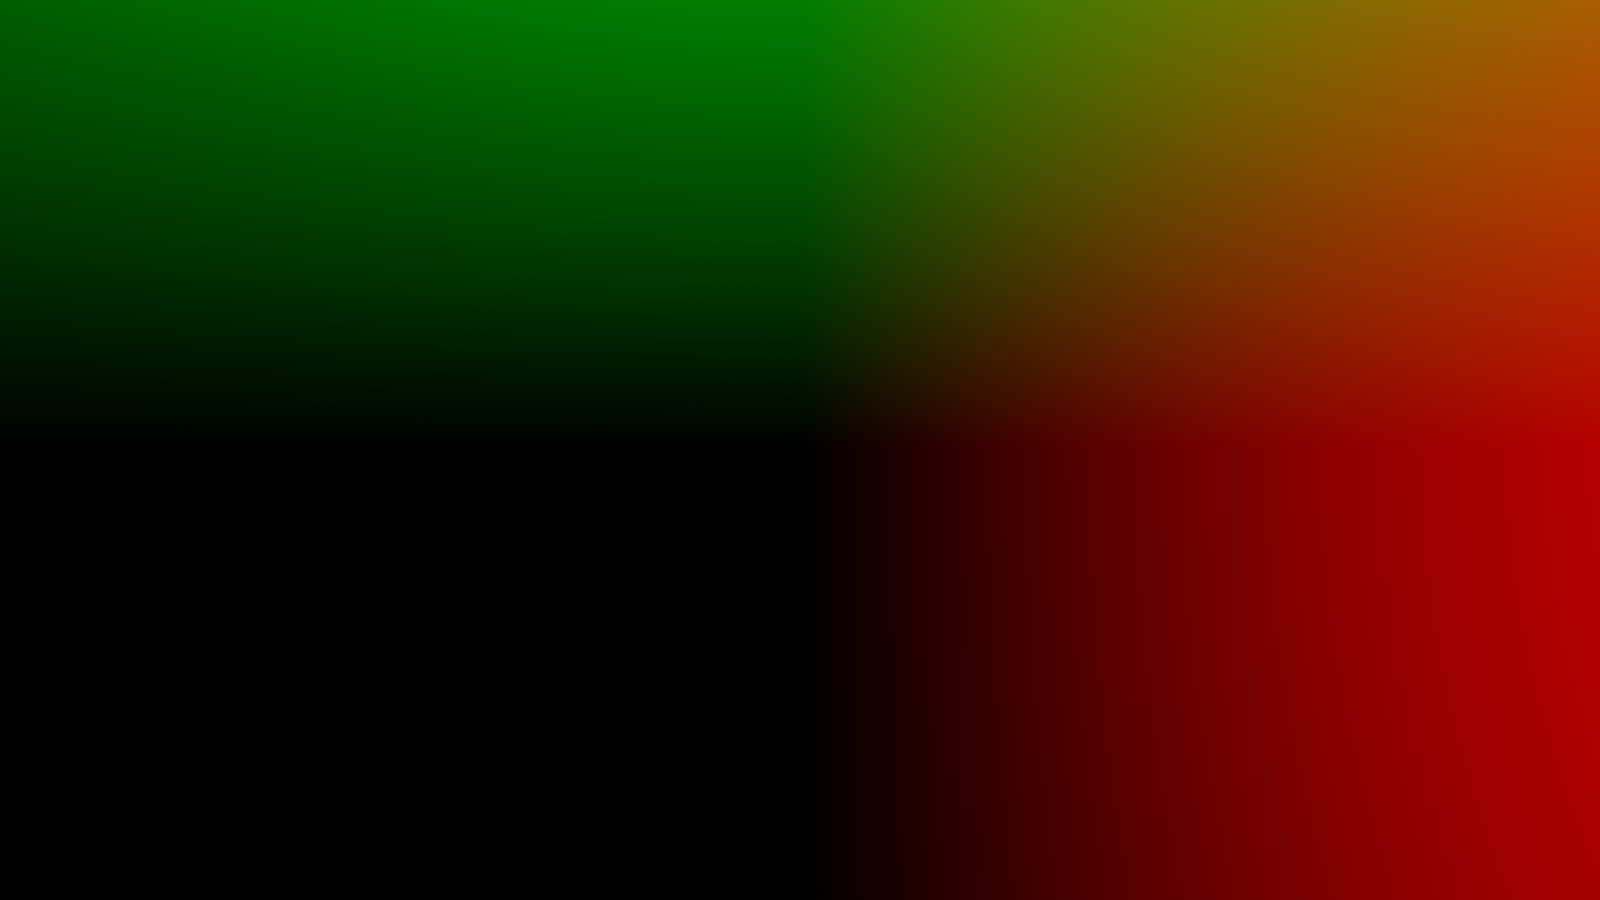

In [51]:
color = rays.dir.to_array()
img_RGB = []
for channel in color:
    img_RGB += [Image.fromarray((255 * np.clip(channel, 0, 1).reshape((camera.screen_height, camera.screen_width))).astype(np.uint8), "L")]

img = Image.merge("RGB", img_RGB)
display(img)

Das obige Bild zeigt die Richtungen der Rays als Farbe. Die Farben werden wie folgt auf die Richtung gemapped:
- Rot = x
- Grün = y
- Blau = z

Im Bild ist kein Blau zu sehen da alle die Rays in die negative z-Richtung zeigen und negative Farbwerte nicht angezeigt werden können. Die negativen z-Werte werden von `np.clip(channel, 0, 1)` auf 0 gezogen.

## Schnittpunkt von Ebene und Ray

Damit ein Punkt auf einer Ebene liegt muss folgende Gleichung erfüllt sein:

$$(\vec{p} - \vec{p_0}) * \vec{n} = 0$$

- $\vec{p}$  Punkt auf Ebene
- $\vec{p_0}$ Mittelpunkt der Ebene
- $\vec{n}$ Normalenvektor der Ebene

Der Ray ist wie folgt definiert:
$$P = \vec{O}+\vec{R}*t$$

- $\vec{O}$ Stützvektor
- $\vec{R}$ Richtungsvektor

Daraus folgt:
$$((\vec{O}+\vec{R}*t) - \vec{p_0}) * \vec{n} = 0$$

Eine Umformung nach t ergibt:
$$t = \frac{(\vec{p_0} - \vec{O}) * \vec{n}}{\vec{R} * \vec{n}}$$

<img src="assets/PlaneIntersection.jpg" width=300></img>

Setzt man t wieder in die Formel des Rays ein erhält man den Schnittpunkt von Ray und Ebene. Der Verbindungsvektor des Schnittpunks mit dem Mittelpunkt der Ebene liegt in der Ebene.
Projiziert man diesen Verbindungsvektor auf die Achsen der Ebene, kann bestimmt werden, ob der Endpunkt der Schnittpunkt innerhalb einer gegeben Breite und Länge der Ebene liegt.